In [1]:
import numpy as np
import os
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils
from random import shuffle
import h5py
from keras import models
from keras import layers
from keras import optimizers
import json
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
from keras.applications.resnet50 import decode_predictions
import matplotlib.image as mpimg

Using TensorFlow backend.


# Functions to use

In [2]:
# a fucntion to plot and print history
def plot_print_history(history, title, to_print=False):
    plt.figure(1, figsize=(14,4))
    plt.suptitle(title, fontsize=12)
    # summarize history for accuracy
    plt.subplot(121)
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower right')
    #plt.show()
    # summarize history for loss
    plt.subplot(122)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()
    # print history as a numpy array
    if to_print == True:
        #print(np.array([history['acc'], history['val_acc'], history['loss'],history['val_loss']]))
        print(history)
    
    # save fig
    #plt.savefig(fig_path)

In [3]:
def save_to_sub(pred, output_name):
    df = pd.read_csv("sample_submission.csv")
    for i, file in enumerate(test_generator.filenames):
        index = int(file[file.rfind('/')+1:file.rfind('.')])
        df.set_value(index-1, 'label', pred[i])
    df.to_csv(output_name, index=None)
    df.head(10)

In [4]:
# the function to save history to a txt file
def save_history(history, output_name):
    with open(output_name, 'w') as file:
        file.write(json.dumps(history)) # use `json.loads` to do the reverse


In [5]:
# the function to save history to a txt file
def load_history(history_name):
    with open(history_name, 'r') as fin:
        data = fin.read()

    history = eval(data)
    return history

In [6]:
# the function to save model
def save_model(model, model_name):
    model_json = model.to_json()
    base_model_path = os.path.join(os.path.abspath(model_path), model_name)
    with open(base_model_path, 'w') as json_file:
          json_file.write(model_json)


In [7]:
# the function to load model
def load_model(model_name):
    json_file = open(model_name, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    
    return model

In [8]:
# load top weights to models
def load_top_weights(model, weights_name):
    model.load_weights(weights_name)
    return model

In [9]:
def save_his_to_csv(history):
    df = pd.DataFrame(data=load_history(history))
    df.to_csv(history[:-4]+'.csv', index=None)

In [10]:
classes = 2
img_size = 299
channels = 3
LR = 1e-4
FC_SIZE = 2048
TRAIN_DIR = 'train_copy'
VALIDATION_DIR = 'validation_copy'
TEST_DIR = 'test'
batch_size = 32
nb_epoch = 10
momentum = .9
transformation_ratio = .05
model_path ='/home/ubuntu/capstone/dog_vs_cat'

In [11]:
#分别对训练集、验证集和测试集构建data generator
datagen = ImageDataGenerator()

#训练集生成器
train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              target_size=(img_size, img_size),
                                              batch_size=batch_size,
                                              class_mode='binary',
                                              shuffle=True)
#验证集生成器
validation_generator = datagen.flow_from_directory(VALIDATION_DIR,
                                                   target_size=(img_size, img_size),
                                                   batch_size=batch_size,
                                                   class_mode='binary',
                                                   shuffle=True)
#测试集生成器
test_generator = datagen.flow_from_directory(TEST_DIR,
                                             target_size=(img_size, img_size),
                                             batch_size=batch_size, shuffle=False)

#用于检验和评价模型的数据集生成器
validation = datagen.flow_from_directory('validation',
                                                   target_size=(img_size, img_size),
                                                   batch_size=batch_size,
                                                   class_mode='binary',
                                                   shuffle=False)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
Found 5000 images belonging to 1 classes.


In [12]:
#定义一个以预训练模型为基础构建新模型的函数
def build_model(model, img_size, dropout, layer_to_train=None, preprocess=None):
    
    '''
    model: 选择的预训练模型
    img_size: tuple, 预训练模型要求的图像输入尺寸,如(299,299)
    layer_to_train: integer, 设置预训练模型中可训练的层数（即倒数几层）
    dropout: float, 随机舍弃率，通常为0.5~0.7
    preprocess: 设置预训练模型相应的预处理方式
    
    '''
    
    #设置输入数据格式为（width, height, channel）
    input_tensor = Input((img_size[0], img_size[1], channels))
    x = input_tensor
    
    #若需要，对数据进行预处理
    if preprocess:
        x = Lambda(preprocess)(x)
    
    #加载预训练模型
    conv_base = model(weights='imagenet',include_top=False,input_tensor=x)
    
    #设置预训练模型中可训练的层数（即倒数几层）
    if layer_to_train:
        for layer in conv_base.layers[:-layer_to_train]:
            layer.trainable = False
        for layer in conv_base.layers[-layer_to_train:]:
            layer.trainable = True
    else:
        for layer in conv_base.layers:
            layer.trainable = False
    
    #增加顶层构建模型
    x = GlobalAveragePooling2D()(conv_base.output)  #在与训练模型上增加池化层
    x = Dropout(dropout)(x)                         #增加dropout层以防止过拟合
    x = Dense(1, activation='sigmoid')(x)           #增加激活层，激活函数使用sigmoid
    model = Model(conv_base.input, x)
    
    #函数返回一个模型
    return model

In [13]:
def train_base_model(model, top_weights, final_model, epoch=10):

    '''
    model: 需要训练的模型
    epoch: integer, 默认训练10代
    top_weights: str, 保存最佳权重值的文件名(.h5),如'top_model_weights_Xception_3layers.h5'
    final_model: str, 保存最终模型的文件名(.json),如'model_Xception_3layers.json'
    
    '''
    
    #设置保存最佳权重值文件的路径
    top_base_weights_name = top_weights
    top_base_weights_path = os.path.join(os.path.abspath(model_path), top_base_weights_name)
    
    callbacks_list = [ModelCheckpoint(top_base_weights_path, monitor='val_loss', verbose=1, save_best_only=True),
                  EarlyStopping(monitor='val_loss', patience=5, verbose=0)]
    
    
    model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])
    
    #训练模型
    base_history = model.fit_generator(train_generator,
                                       steps_per_epoch=20000//batch_size,
                                       epochs=epoch,
                                       validation_data=validation_generator,
                                       validation_steps=5000//batch_size,
                                       shuffle=True,
                                       callbacks=callbacks_list)
    
    #保存模型
    model_name = final_model
    save_model(model, model_name)
    
    return model, base_history.history

In [14]:
#模型预测数据并做后续clip处理
def predict(model, generator):
    pred = model.predict_generator(generator, verbose=1)
    pred = pred.clip(min=0.005, max=0.995)
    return pred

# Using pretrained model to eliminate outliers

In [15]:
dogs = [
 'n02085620','n02085782','n02085936','n02086079'
,'n02086240','n02086646','n02086910','n02087046'
,'n02087394','n02088094','n02088238','n02088364'
,'n02088466','n02088632','n02089078','n02089867'
,'n02089973','n02090379','n02090622','n02090721'
,'n02091032','n02091134','n02091244','n02091467'
,'n02091635','n02091831','n02092002','n02092339'
,'n02093256','n02093428','n02093647','n02093754'
,'n02093859','n02093991','n02094114','n02094258'
,'n02094433','n02095314','n02095570','n02095889'
,'n02096051','n02096177','n02096294','n02096437'
,'n02096585','n02097047','n02097130','n02097209'
,'n02097298','n02097474','n02097658','n02098105'
,'n02098286','n02098413','n02099267','n02099429'
,'n02099601','n02099712','n02099849','n02100236'
,'n02100583','n02100735','n02100877','n02101006'
,'n02101388','n02101556','n02102040','n02102177'
,'n02102318','n02102480','n02102973','n02104029'
,'n02104365','n02105056','n02105162','n02105251'
,'n02105412','n02105505','n02105641','n02105855'
,'n02106030','n02106166','n02106382','n02106550'
,'n02106662','n02107142','n02107312','n02107574'
,'n02107683','n02107908','n02108000','n02108089'
,'n02108422','n02108551','n02108915','n02109047'
,'n02109525','n02109961','n02110063','n02110185'
,'n02110341','n02110627','n02110806','n02110958'
,'n02111129','n02111277','n02111500','n02111889'
,'n02112018','n02112137','n02112350','n02112706'
,'n02113023','n02113186','n02113624','n02113712'
,'n02113799','n02113978']

cats=[
'n02123045','n02123159','n02123394','n02123597'
,'n02124075','n02125311','n02127052']

In [16]:
#设置Top N来检测异常值
def detect_outliers(pred, n):
    topN = decode_predictions(pred, top=n)
    outliers= []
    for num in range(len(topN)):
        count=0
        for i in range(n):
            if topN[num][i][0] in dogs:
                count+=1
            if topN[num][i][0] in cats:
                count+=1
        if count==0:
            outliers.append(raw.filenames[num].split('/')[-1])
            
    return outliers

In [17]:
#显示被侦测为异常值的图片
def display_outliers(outliers, col=4, fig_size=(40, 50)):
    print(len(outliers))
    fig = plt.figure(1, fig_size)
    row = int(len(outliers)/col) + 1
    for k in range(len(outliers)):
        fig.add_subplot(row, col, k+1)
        plt.title(outliers[k])
        img=mpimg.imread('raw/raw/'+outliers[k])
        plt.imshow(img)
        plt.axis('off')
    plt.show()
            

## ResNet50

In [189]:
#ResNet50数据预处理
from keras.applications.resnet50 import preprocess_input
datagen2 = ImageDataGenerator(preprocessing_function=preprocess_input)
raw = datagen2.flow_from_directory('raw',
                                   target_size=(224, 224),
                                   batch_size=batch_size,
                                   shuffle=False)

Found 20000 images belonging to 1 classes.


In [45]:
ResNet50 = ResNet50()
pred_ResNet50 = ResNet50.predict_generator(raw, verbose=1)

625/625 [==============================] - 192s 307ms/step


In [ ]:
outliers_ResNet50 = detect_outliers(pred_ResNet50, 45)
display_outliers(outliers_ResNet50)
#会得到35个异常值

## DenseNet

In [186]:
#DenseNet数据预处理
datagen2 = ImageDataGenerator(preprocessing_function=densenet.preprocess_input)
raw = datagen2.flow_from_directory('raw',
                                   target_size=(224, 224),
                                   batch_size=batch_size,
                                   shuffle=False)

Found 20000 images belonging to 1 classes.


In [35]:
DenseNet201 = DenseNet201()
pred_DenseNet201 = DenseNet201.predict_generator(raw, verbose=1)

625/625 [==============================] - 317s 507ms/step


In [ ]:
outliers_DenseNet201 = detect_outliers(pred_DenseNet201, 40)
display_outliers(outliers_DenseNet201)
#会得到23个异常值

## InceptionResNetV2

In [191]:
#InceptionResNetV2数据预处理
datagen2 = ImageDataGenerator(preprocessing_function=inception_resnet_v2.preprocess_input)
raw = datagen2.flow_from_directory('raw',
                                   target_size=(299, 299),
                                   batch_size=batch_size,
                                   shuffle=False)

Found 20000 images belonging to 1 classes.


In [28]:
InceptionResNetV2 = InceptionResNetV2()
pred_InceptionResNetV2 = InceptionResNetV2.predict_generator(raw, verbose=1)

625/625 [==============================] - 574s 919ms/step


In [ ]:
outliers_InceptionResNetV2 = detect_outliers(pred_InceptionResNetV2, 50)
display_outliers(outliers_InceptionResNetV2)
#会得到25个异常值

## Aggregation of outliers

In [52]:
#汇总所有异常值
outliers = outliers_ResNet50 + outliers_DenseNet201 + outliers_InceptionResNetV2

In [53]:
train_cat = [i for i in os.listdir('/home/ubuntu/capstone/dog_vs_cat/train_copy_2/cat/')]
train_dog = [i for i in os.listdir('/home/ubuntu/capstone/dog_vs_cat/train_copy_2/dog/')]

In [54]:
#从训练集中删除异常值
for i in train_cat:
    if i in outliers:
        os.remove('/home/ubuntu/capstone/dog_vs_cat/train_copy_2/cat/'+i)
for i in train_dog:
    if i in outliers:
        os.remove('/home/ubuntu/capstone/dog_vs_cat/train_copy_2/dog/'+i)

In [58]:
#just record
print(outliers)
print(len(outliers))

['cat.10365.jpg', 'cat.10536.jpg', 'cat.10712.jpg', 'cat.12272.jpg', 'cat.12476.jpg', 'cat.2457.jpg', 'cat.2520.jpg', 'cat.2939.jpg', 'cat.3216.jpg', 'cat.3672.jpg', 'cat.5418.jpg', 'cat.5974.jpg', 'cat.6348.jpg', 'cat.7377.jpg', 'cat.7564.jpg', 'cat.8921.jpg', 'cat.9171.jpg', 'dog.10123.jpg', 'dog.10161.jpg', 'dog.10190.jpg', 'dog.10237.jpg', 'dog.11437.jpg', 'dog.1194.jpg', 'dog.12376.jpg', 'dog.1625.jpg', 'dog.2422.jpg', 'dog.2614.jpg', 'dog.4218.jpg', 'dog.4367.jpg', 'dog.4507.jpg', 'dog.5604.jpg', 'dog.6475.jpg', 'dog.6725.jpg', 'dog.8736.jpg', 'dog.9517.jpg', 'cat.10029.jpg', 'cat.10365.jpg', 'cat.12272.jpg', 'cat.2429.jpg', 'cat.2939.jpg', 'cat.3216.jpg', 'cat.5351.jpg', 'cat.7377.jpg', 'cat.7968.jpg', 'dog.10190.jpg', 'dog.10237.jpg', 'dog.1043.jpg', 'dog.12376.jpg', 'dog.1259.jpg', 'dog.1895.jpg', 'dog.2614.jpg', 'dog.4507.jpg', 'dog.5604.jpg', 'dog.6475.jpg', 'dog.6725.jpg', 'dog.8736.jpg', 'dog.9188.jpg', 'dog.9517.jpg', 'cat.10029.jpg', 'cat.10712.jpg', 'cat.2520.jpg', 'cat

In [59]:
check = []
for outlier in outliers:
    if outlier not in check:
        check.append(outlier)
print(len(check))
print(check)

47
['cat.10365.jpg', 'cat.10536.jpg', 'cat.10712.jpg', 'cat.12272.jpg', 'cat.12476.jpg', 'cat.2457.jpg', 'cat.2520.jpg', 'cat.2939.jpg', 'cat.3216.jpg', 'cat.3672.jpg', 'cat.5418.jpg', 'cat.5974.jpg', 'cat.6348.jpg', 'cat.7377.jpg', 'cat.7564.jpg', 'cat.8921.jpg', 'cat.9171.jpg', 'dog.10123.jpg', 'dog.10161.jpg', 'dog.10190.jpg', 'dog.10237.jpg', 'dog.11437.jpg', 'dog.1194.jpg', 'dog.12376.jpg', 'dog.1625.jpg', 'dog.2422.jpg', 'dog.2614.jpg', 'dog.4218.jpg', 'dog.4367.jpg', 'dog.4507.jpg', 'dog.5604.jpg', 'dog.6475.jpg', 'dog.6725.jpg', 'dog.8736.jpg', 'dog.9517.jpg', 'cat.10029.jpg', 'cat.2429.jpg', 'cat.5351.jpg', 'cat.7968.jpg', 'dog.1043.jpg', 'dog.1259.jpg', 'dog.1895.jpg', 'dog.9188.jpg', 'cat.4338.jpg', 'cat.4688.jpg', 'cat.5071.jpg', 'cat.8470.jpg']


In [56]:
classes = 2
img_size = 299
channels = 3
LR = 1e-4
FC_SIZE = 2048
TRAIN_DIR = 'train_copy'
VALIDATION_DIR = 'validation_copy'
TEST_DIR = 'test'
batch_size = 32
nb_epoch = 10
momentum = .9
transformation_ratio = .05
model_path ='/home/ubuntu/capstone/dog_vs_cat'

In [57]:
#分别对训练集、验证集和测试集构建data generator
datagen = ImageDataGenerator()

#剔除异常值后的训练集生成器
train_generator = datagen.flow_from_directory('train_copy_2',
                                              target_size=(img_size, img_size),
                                              batch_size=batch_size,
                                              class_mode='binary',
                                              shuffle=True)

Found 19953 images belonging to 2 classes.


# Xception - 3 layers to train - dropout=0.5 - last conv in block 14

In [60]:
model = build_model(Xception, (299, 299), layer_to_train=3, dropout=0.5, preprocess=xception.preprocess_input)
model, history = train_base_model(model, 
                                  epoch=10, 
                                  top_weights='top_model_weights_Xception_3layers_dropout0.5_no_outliers.h5', 
                                  final_model='model_Xception_3layers_dropout0.5_no_outliers.json')
history_name = 'history_Xception_adadelta_3layers_dropout0.5_no_outliers.txt'
save_history(history, history_name)

Epoch 1/10
624/625 [============================>.] - ETA: 0s - loss: 0.0470 - acc: 0.9853
Epoch 00001: val_loss improved from inf to 0.02186, saving model to /home/ubuntu/capstone/dog_vs_cat/top_model_weights_Xception_3layers_dropout0.5_no_outliers.h5
625/625 [==============================] - 644s 1s/step - loss: 0.0469 - acc: 0.9853 - val_loss: 0.0219 - val_acc: 0.9936
Epoch 2/10
624/625 [============================>.] - ETA: 0s - loss: 0.0271 - acc: 0.9903
Epoch 00002: val_loss did not improve
625/625 [==============================] - 465s 744ms/step - loss: 0.0271 - acc: 0.9903 - val_loss: 0.0236 - val_acc: 0.9921
Epoch 3/10
624/625 [============================>.] - ETA: 0s - loss: 0.0221 - acc: 0.9925
Epoch 00003: val_loss did not improve
625/625 [==============================] - 465s 744ms/step - loss: 0.0221 - acc: 0.9925 - val_loss: 0.0226 - val_acc: 0.9928
Epoch 4/10
624/625 [============================>.] - ETA: 0s - loss: 0.0158 - acc: 0.9948
Epoch 00004: val_loss did 

In [61]:
save_his_to_csv('history_Xception_adadelta_3layers_dropout0.5_no_outliers.txt')

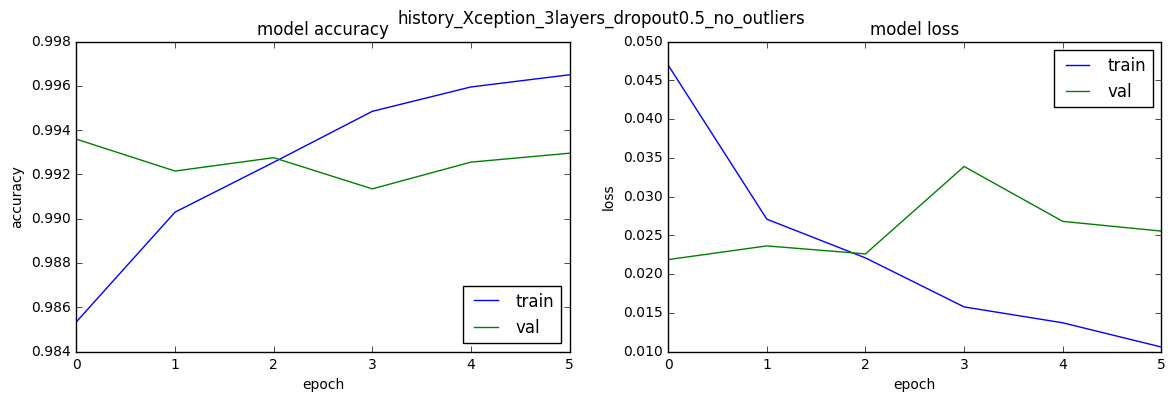

{'val_loss': [0.021858758209325455, 0.023624532831114403, 0.022594466646254023, 0.03387338615233684, 0.026788919281034322, 0.02553549201479911], 'loss': [0.046945616419382594, 0.02707219328624116, 0.022075553036329597, 0.015754392356752755, 0.013703214709707232, 0.010576713669715201], 'acc': [0.9853390042531899, 0.9902927195396547, 0.9925444083092121, 0.9948461346009507, 0.9959469602201652, 0.9964973730297724], 'val_acc': [0.9935897435897436, 0.9921497584541062, 0.9927536231884058, 0.9913446054750402, 0.9925523349436393, 0.9929549114331723]}


In [62]:
history = load_history('history_Xception_adadelta_3layers_dropout0.5_no_outliers.txt')
plot_print_history(history, title='history_Xception_3layers_dropout0.5_no_outliers', to_print=True)

In [63]:
#使用训练完成后最终的权重值在测试集上预测
pred = predict(model, test_generator)
save_to_sub(pred, 'submission20180416_3layers_dropout0.5_no_outliers_final_weights.csv')

391/391 [==============================] - 251s 641ms/step


In [65]:
#submission20180318_3layers_dropout0.5_final_weights.csv
#test logloss 0.04467

In [66]:
#submission20180416_3layers_no_outliers_final_weights.csv
#test logloss 0.04994

In [67]:
#使用在验证集上表现最好的权重值在测试集上预测预测
model.load_weights('top_model_weights_Xception_3layers_dropout0.5_no_outliers.h5')
pred = predict(model, test_generator)
save_to_sub(pred, 'submission20180416_3layers_dropout0.5_no_outliers_top_weights.csv')

391/391 [==============================] - 247s 633ms/step


In [68]:
#submission20180318_3layers_dropout0.5_top_weights.csv
#test logloss 0.04374

In [ ]:
#submission20180416_3layers_dropout0.5_no_outliers_top_weights.csv
#test logloss 0.04901

# Xception - 6 layers to train - dropout=0.5 - block 14

In [ ]:
model = build_model(Xception, (299, 299), layer_to_train=6, dropout=0.5, preprocess=xception.preprocess_input)
model, history = train_base_model(model, 
                                  epoch=10, 
                                  top_weights='top_model_weights_Xception_6layers_dropout0.5_no_outliers.h5', 
                                  final_model='model_Xception_6layers_dropout0.5_no_outliers.json')
history_name = 'history_Xception_adadelta_6layers_dropout0.5_no_outliers.txt'
save_history(history, history_name)

Epoch 1/10
 56/625 [=>............................] - ETA: 6:55 - loss: 0.1053 - acc: 0.9632

In [ ]:
save_his_to_csv('history_Xception_adadelta_6layers_dropout0.5_no_outliers.txt')

In [ ]:
history = load_history('history_Xception_adadelta_6layers_dropout0.5_no_outliers.txt')
plot_print_history(history, title='history_Xception_6layers_dropout0.5_no_outliers', to_print=True)

In [ ]:
#使用训练完成后最终的权重值在测试集上预测
pred = predict(model, test_generator)
save_to_sub(pred, 'submission20180416_6layers_dropout0.5_no_outliers_final_weights.csv')

In [ ]:
#submission20180318_6layers_final_weights.csv
#test logloss 0.04923

In [ ]:
#submission20180416_6layers_dropout0.5_no_outliers_final_weights.csv
#test logloss 0.04635

In [ ]:
#使用在验证集上表现最好的权重值在测试集上预测预测
model.load_weights('top_model_weights_Xception_6layers_dropout0.5_no_outliers.h5')
pred = predict(model, test_generator)
save_to_sub(pred, 'submission20180416_6layers_dropout0.5_no_outliers_top_weights.csv')

In [ ]:
#submission20180318_6layers_top_weights.csv
#test logloss 0.04500

In [ ]:
#submission20180416_6layers_no_outliers_top_weights.csv
#test logloss 0.04696

# Xception - 16 layers to train - dropout=0.5 - block 13 & 14

In [ ]:
model = build_model(Xception, (299, 299), layer_to_train=16, dropout=0.5, preprocess=xception.preprocess_input)
model, history = train_base_model(model, 
                                  epoch=10, 
                                  top_weights='top_model_weights_Xception_16layers_dropout0.5_no_outliers.h5', 
                                  final_model='model_Xception_16layers_dropout0.5_no_outliers.json')
history_name = 'history_Xception_adadelta_16layers_dropout0.5_no_outliers.txt'
save_history(history, history_name)

In [ ]:
save_his_to_csv('history_Xception_adadelta_16layers_dropout0.5_no_outliers.txt')

In [ ]:
history = load_history('history_Xception_adadelta_16layers_dropout0.5_no_outliers.txt')
plot_print_history(history, title='history_Xception_16layers_dropout0.5_no_outliers', to_print=True)

In [ ]:
#使用训练完成后最终的权重值在测试集上预测
pred = predict(model, test_generator)
save_to_sub(pred, 'submission20180416_16layers_dropout0.5_no_outliers_final_weights.csv')

In [ ]:
#submission20180318_16layers_dropout0.5_final_weights.csv
#test logloss 0.04461

In [ ]:
#submission20180416_16layers_dropout0.5_no_outliers_final_weights.csv
#test logloss 0.03954

In [ ]:
#使用在验证集上表现最好的权重值在测试集上预测预测
model.load_weights('top_model_weights_Xception_16layers_dropout0.5_no_outliers.h5')
pred = predict(model, test_generator)
save_to_sub(pred, 'submission20180416_16layers_dropout0.5_no_outliers_top_weights.csv')

In [ ]:
#submission20180318_16layers_dropout0.5_top_weights.csv
#test logloss 0.03993

In [ ]:
#submission20180416_16layers_dropout0.5_no_outliers_top_weights.csv
#test logloss 0.03925

# Xception - 3 layers to train - dropout=0.7 - last conv in block 14

In [ ]:
model = build_model(Xception, (299, 299), layer_to_train=3, dropout=0.7, preprocess=xception.preprocess_input)
model, history = train_base_model(model, 
                                  epoch=10, 
                                  top_weights='top_model_weights_Xception_3layers_dropout0.7_no_outliers.h5', 
                                  final_model='model_Xception_3layers_dropout0.7_no_outliers.json')
history_name = 'history_Xception_adadelta_3layers_dropout0.7_no_outliers.txt'
save_history(history, history_name)

In [ ]:
save_his_to_csv('history_Xception_adadelta_3layers_dropout0.7_no_outliers.txt')

In [ ]:
history = load_history('history_Xception_adadelta_3layers_dropout0.7_no_outliers.txt')
plot_print_history(history, title='history_Xception_3layers_dropout0.7_no_outliers', to_print=True)

In [ ]:
#使用训练完成后最终的权重值在测试集上预测
pred = predict(model, test_generator)
save_to_sub(pred, 'submission20180416_3layers_dropout0.7_no_outliers_final_weights.csv')

In [ ]:
#submission20180318_3layers_dropout0.7_final_weights.csv
#test logloss 0.04899

In [ ]:
#submission20180416_3layers_dropout0.7_no_outliers_final_weights.csv
#test logloss 0.04887

In [ ]:
#使用在验证集上表现最好的权重值在测试集上预测预测
model.load_weights('top_model_weights_Xception_3layers_dropout0.7_no_outliers.h5')
pred = predict(model, test_generator)
save_to_sub(pred, 'submission20180416_3layers_dropout0.7_no_outliers_top_weights.csv')

In [ ]:
#submission20180318_3layers_dropout0.7_top_weights.csv
#test logloss 0.04844

In [ ]:
#submission20180416_3layers_dropout0.7_no_outliers_top_weights.csv
#test logloss 0.04742

# Xception - 6 layers to train - dropout=0.7 - block 14

In [ ]:
model = build_model(Xception, (299, 299), layer_to_train=6, dropout=0.7, preprocess=xception.preprocess_input)
model, history = train_base_model(model, 
                                  epoch=10, 
                                  top_weights='top_model_weights_Xception_6layers_dropout0.7_no_outliers.h5', 
                                  final_model='model_Xception_6layers_dropout0.7_no_outliers.json')
history_name = 'history_Xception_adadelta_6layers_dropout0.7_no_outliers.txt'
save_history(history, history_name)

In [ ]:
save_his_to_csv('history_Xception_adadelta_6layers_dropout0.7_no_outliers.txt')

In [ ]:
history = load_history('history_Xception_adadelta_6layers_dropout0.7_no_outliers.txt')
plot_print_history(history, title='history_Xception_6layers_dropout0.7_no_outliers', to_print=True)

In [ ]:
#使用训练完成后最终的权重值在测试集上预测
pred = predict(model, test_generator)
save_to_sub(pred, 'submission20180416_6layers_dropout0.7_no_outliers_final_weights.csv')

In [ ]:
#submission20180318_6layers_dropout0.7_final_weights.csv
#test logloss 0.05162

In [ ]:
#submission20180416_6layers_dropout0.7_no_outliers_final_weights.csv
#test logloss 0.04708

In [ ]:
#使用在验证集上表现最好的权重值在测试集上预测预测
model.load_weights('top_model_weights_Xception_6layers_dropout0.7_no_outliers.h5')
pred = predict(model, test_generator)
save_to_sub(pred, 'submission20180416_6layers_dropout0.7_no_outliers_top_weights.csv')

In [ ]:
#submission20180318_6layers_dropout0.7_top_weights.csv
#test logloss 0.04205

In [ ]:
#submission20180416_6layers_dropout0.7_no_outliers_top_weights.csv
#test logloss 0.04499

# Xception - 16 layers to train - dropout=0.7 - block 13 & 14

In [ ]:
model = build_model(Xception, (299, 299), layer_to_train=16, dropout=0.7, preprocess=xception.preprocess_input)
model, history = train_base_model(model, 
                                  epoch=10, 
                                  top_weights='top_model_weights_Xception_16layers_dropout0.7_no_outliers.h5', 
                                  final_model='model_Xception_16layers_dropout0.7_no_outliers.json')
history_name = 'history_Xception_adadelta_16layers_dropout0.7_no_outliers.txt'
save_history(history, history_name)

In [ ]:
save_his_to_csv('history_Xception_adadelta_16layers_dropout0.7_no_outliers.txt')

In [ ]:
history = load_history('history_Xception_adadelta_16layers_dropout0.7_no_outliers.txt')
plot_print_history(history, title='history_Xception_16layers_dropout0.7_no_outliers', to_print=True)

In [ ]:
#使用训练完成后最终的权重值在测试集上预测
pred = predict(model, test_generator)
save_to_sub(pred, 'submission20180416_16layers_dropout0.7_no_outliers_final_weights.csv')

In [ ]:
#submission20180318_16layers_dropout0.7_final_weights.csv
#test logloss 0.04120

In [ ]:
#submission20180416_16layers_dropout0.7_no_outliers_final_weights.csv
#test logloss 0.04075

In [ ]:
#使用在验证集上表现最好的权重值在测试集上预测预测
model.load_weights('top_model_weights_Xception_16layers_dropout0.7_no_outliers.h5')
pred = predict(model, test_generator)
save_to_sub(pred, 'submission20180416_16layers_dropout0.7_no_outliers_top_weights.csv')

In [ ]:
#submission20180318_16layers_dropout0.7_top_weights.csv
#test logloss 0.04065

In [ ]:
#submission20180416_16layers_dropout0.7_no_outliers_top_weights.csv
#test logloss 0.03989

# Xception - 3 layers to train - dropout=0.6 - last conv in block 14

In [ ]:
model = build_model(Xception, (299, 299), layer_to_train=3, dropout=0.6, preprocess=xception.preprocess_input)
model, history = train_base_model(model, 
                                  epoch=10, 
                                  top_weights='top_model_weights_Xception_3layers_dropout0.6_no_outliers.h5', 
                                  final_model='model_Xception_3layers_dropout0.6_no_outliers.json')
history_name = 'history_Xception_adadelta_3layers_dropout0.6_no_outliers.txt'
save_history(history, history_name)

In [ ]:
save_his_to_csv('history_Xception_adadelta_3layers_dropout0.6_no_outliers.txt')

In [ ]:
history = load_history('history_Xception_adadelta_3layers_dropout0.6_no_outliers.txt')
plot_print_history(history, title='history_Xception_3layers_dropout0.6_no_outliers', to_print=True)

In [ ]:
#使用训练完成后最终的权重值在测试集上预测
pred = predict(model, test_generator)
save_to_sub(pred, 'submission20180416_3layers_dropout0.6_no_outliers_final_weights.csv')

In [ ]:
#submission20180318_3layers_dropout0.6_final_weights.csv
#test logloss 0.05009

In [ ]:
#submission20180416_3layers_dropout0.6_no_outliers_final_weights.csv
#test logloss 0.05473

In [ ]:
#使用在验证集上表现最好的权重值在测试集上预测预测
model.load_weights('top_model_weights_Xception_3layers_dropout0.6_no_outliers.h5')
pred = predict(model, test_generator)
save_to_sub(pred, 'submission20180416_3layers_dropout0.6_no_outliers_top_weights.csv')

In [ ]:
#submission20180318_3layers_dropout0.6_top_weights.csv
#test logloss 0.04679

In [ ]:
#submission20180416_3layers_dropout0.6_no_outliers_top_weights.csv
#test logloss 0.04909

# Xception - 6 layers to train - dropout=0.6 - block 14

In [ ]:
model = build_model(Xception, (299, 299), layer_to_train=6, dropout=0.6, preprocess=xception.preprocess_input)
model, history = train_base_model(model, 
                                  epoch=10, 
                                  top_weights='top_model_weights_Xception_6layers_dropout0.6_no_outliers.h5', 
                                  final_model='model_Xception_6layers_dropout0.6_no_outliers.json')
history_name = 'history_Xception_adadelta_6layers_dropout0.6_no_outliers.txt'
save_history(history, history_name)

In [ ]:
save_his_to_csv('history_Xception_adadelta_6layers_dropout0.6_no_outliers.txt')

In [ ]:
history = load_history('history_Xception_adadelta_6layers_dropout0.6_no_outliers.txt')
plot_print_history(history, title='history_Xception_6layers_dropout0.6_no_outliers', to_print=True)

In [ ]:
#使用训练完成后最终的权重值在测试集上预测
pred = predict(model, test_generator)
save_to_sub(pred, 'submission20180416_6layers_dropout0.6_no_outliers_final_weights.csv')

In [ ]:
#submission20180318_6layers_dropout0.6_final_weights.csv
#test logloss 0.05379

In [ ]:
#submission20180416_6layers_dropout0.6_no_outliers_final_weights.csv
#test logloss 0.05021

In [ ]:
#使用在验证集上表现最好的权重值在测试集上预测预测
model.load_weights('top_model_weights_Xception_6layers_dropout0.6_no_outliers.h5')
pred = predict(model, test_generator)
save_to_sub(pred, 'submission20180416_6layers_dropout0.6_no_outliers_top_weights.csv')

In [ ]:
#submission20180318_6layers_dropout0.6_top_weights.csv
#test logloss 0.04679

In [ ]:
#submission20180416_6layers_dropout0.6_no_outliers_top_weights.csv
#test logloss 0.04577

# Xception - 16 layers to train - dropout=0.6 - block 13 & 14

In [ ]:
model = build_model(Xception, (299, 299), layer_to_train=16, dropout=0.6, preprocess=xception.preprocess_input)
model, history = train_base_model(model, 
                                  epoch=10, 
                                  top_weights='top_model_weights_Xception_16layers_dropout0.6_no_outliers.h5', 
                                  final_model='model_Xception_16layers_dropout0.6_no_outliers.json')
history_name = 'history_Xception_adadelta_16layers_dropout0.6_no_outliers.txt'
save_history(history, history_name)

In [ ]:
save_his_to_csv('history_Xception_adadelta_16layers_dropout0.6_no_outliers.txt')

In [ ]:
history = load_history('history_Xception_adadelta_16layers_dropout0.6_no_outliers.txt')
plot_print_history(history, title='history_Xception_16layers_dropout0.6_no_outliers', to_print=True)

In [ ]:
#使用训练完成后最终的权重值在测试集上预测
pred = predict(model, test_generator)
save_to_sub(pred, 'submission20180416_16layers_dropout0.6_no_outliers_final_weights.csv')

In [ ]:
#submission20180318_16layers_dropout0.6_final_weights.csv
#test logloss 0.04794

In [ ]:
#submission20180416_16layers_dropout0.6_no_outliers_final_weights.csv
#test logloss 0.04156

In [ ]:
#使用在验证集上表现最好的权重值在测试集上预测预测
model.load_weights('top_model_weights_Xception_16layers_dropout0.6_no_outliers.h5')
pred = predict(model, test_generator)
save_to_sub(pred, 'submission20180416_16layers_dropout0.6_no_outliers_top_weights.csv')

In [ ]:
#submission20180318_16layers_dropout0.6_top_weights.csv
#test logloss 0.03896

In [ ]:
#submission20180416_16layers_dropout0.6_no_outliers_top_weights.csv
#test logloss 0.03911

# Xception - 26 layers to train - dropout=0.5 - block 12, 13 & 14

In [ ]:
model = build_model(Xception, (299, 299), layer_to_train=26, dropout=0.5, preprocess=xception.preprocess_input)
model, history = train_base_model(model, 
                                  epoch=10, 
                                  top_weights='top_model_weights_Xception_26layers_dropout0.5_no_outliers.h5', 
                                  final_model='model_Xception_26layers_dropout0.5_no_outliers.json')
history_name = 'history_Xception_adadelta_26layers_dropout0.5_no_outliers.txt'
save_history(history, history_name)

In [ ]:
save_his_to_csv('history_Xception_adadelta_26layers_dropout0.5_no_outliers.txt')

In [ ]:
history = load_history('history_Xception_adadelta_26layers_dropout0.5_no_outliers.txt')
plot_print_history(history, title='history_Xception_26layers_dropout0.5_no_outliers', to_print=True)

In [ ]:
#使用训练完成后最终的权重值在测试集上预测
pred = predict(model, test_generator)
save_to_sub(pred, 'submission20180416_26layers_dropout0.5_no_outliers_final_weights.csv')

In [ ]:
#submission20180318_26layers_dropout0.5_final_weights.csv
#test logloss 0.04418

In [ ]:
#submission20180416_26layers_dropout0.5_no_outliers_final_weights.csv
#test logloss 0.04366

In [ ]:
#使用在验证集上表现最好的权重值在测试集上预测预测
model.load_weights('top_model_weights_Xception_26layers_dropout0.5_no_outliers.h5')
pred = predict(model, test_generator)
save_to_sub(pred, 'submission20180416_26layers_dropout0.5_no_outliers_top_weights.csv')

In [ ]:
#submission20180318_26layers_dropout0.5_top_weights.csv
#test logloss 0.04489

In [ ]:
#submission20180416_26layers_dropout0.5_no_outliers_top_weights.csv
#test logloss 0.03992

# Xception - 26 layers to train - dropout=0.6 - block 12, 13 & 14

In [ ]:
model = build_model(Xception, (299, 299), layer_to_train=26, dropout=0.6, preprocess=xception.preprocess_input)
model, history = train_base_model(model, 
                                  epoch=10, 
                                  top_weights='top_model_weights_Xception_26layers_dropout0.6_no_outliers.h5', 
                                  final_model='model_Xception_26layers_dropout0.6_no_outliers.json')
history_name = 'history_Xception_adadelta_26layers_dropout0.6_no_outliers.txt'
save_history(history, history_name)

In [ ]:
save_his_to_csv('history_Xception_adadelta_26layers_dropout0.6_no_outliers.txt')

In [ ]:
history = load_history('history_Xception_adadelta_26layers_dropout0.6_no_outliers.txt')
plot_print_history(history, title='history_Xception_26layers_dropout0.6_no_outliers', to_print=True)

In [ ]:
#使用训练完成后最终的权重值在测试集上预测
pred = predict(model, test_generator)
save_to_sub(pred, 'submission20180416_26layers_dropout0.6_no_outliers_final_weights.csv')

In [ ]:
#submission20180318_26layers_dropout0.6_final_weights.csv
#test logloss 0.05169

In [ ]:
#submission20180416_26layers_dropout0.6_no_outliers_final_weights.csv
#test logloss 0.04469

In [ ]:
#使用在验证集上表现最好的权重值在测试集上预测预测
model.load_weights('top_model_weights_Xception_26layers_dropout0.6_no_outliers.h5')
pred = predict(model, test_generator)
save_to_sub(pred, 'submission20180416_26layers_dropout0.6_no_outliers_top_weights.csv')

In [ ]:
#submission20180318_26layers_dropout0.6_top_weights.csv
#test logloss 0.03868
#best model with outliers

In [ ]:
#submission20180416_26layers_dropout0.6_no_outliers_top_weights.csv
#test logloss 0.04387

# Xception - 26 layers to train - dropout=0.7 - block 12, 13 & 14

In [ ]:
model = build_model(Xception, (299, 299), layer_to_train=26, dropout=0.7, preprocess=xception.preprocess_input)
model, history = train_base_model(model, 
                                  epoch=10, 
                                  top_weights='top_model_weights_Xception_26layers_dropout0.7_no_outliers.h5', 
                                  final_model='model_Xception_26layers_dropout0.7_no_outliers.json')
history_name = 'history_Xception_adadelta_26layers_dropout0.7_no_outliers.txt'
save_history(history, history_name)

In [ ]:
save_his_to_csv('history_Xception_adadelta_26layers_dropout0.7_no_outliers.txt')

In [ ]:
history = load_history('history_Xception_adadelta_26layers_dropout0.7_no_outliers.txt')
plot_print_history(history, title='history_Xception_26layers_dropout0.7_no_outliers', to_print=True)

In [ ]:
#使用训练完成后最终的权重值在测试集上预测
pred = predict(model, test_generator)
save_to_sub(pred, 'submission20180416_26layers_dropout0.7_no_outliers_final_weights.csv')

In [ ]:
#submission20180318_26layers_dropout0.7_final_weights.csv
#test logloss 0.04498

In [ ]:
#submission20180416_26layers_dropout0.7_no_outliers_final_weights.csv
#test logloss 0.04018

In [ ]:
#使用在验证集上表现最好的权重值在测试集上预测预测
model.load_weights('top_model_weights_Xception_26layers_dropout0.7_no_outliers.h5')
pred = predict(model, test_generator)
save_to_sub(pred, 'submission20180416_26layers_dropout0.7_no_outliers_top_weights.csv')

In [ ]:
#submission20180318_26layers_dropout0.7_top_weights.csv
#test logloss 0.03958

In [ ]:
#submission20180416_26layers_dropout0.7_no_outliers_top_weights.csv
#test logloss 0.03921

# Validation

In [195]:
model = build_model(Xception, (299, 299), layer_to_train=16, dropout=0.6, preprocess=xception.preprocess_input)

In [196]:
model = load_top_weights(model, 'top_model_weights_Xception_16layers_dropout0.6_no_outliers.h5')

In [197]:
valid_pred = predict(model, validation)

157/157 [==============================] - 112s 713ms/step


In [198]:
back_up = valid_pred.reshape((5000))

In [199]:
#提取出所有被错误预测为狗的猫图片（这里假设最终预测概率超过0.2的猫就被认为是预测为狗）
#输出为图片在数据集中的序号（index）
wrong_dog = np.array(np.where(back_up[:2500]>0.2))

In [200]:
#根据上面提取出的序号来提取图片的文件名
wrong_dog_list = []
for i in wrong_dog[0]:
    wrong_dog_list.append(validation.filenames[i].split('/')[-1])

In [201]:
#将提取的文件名与最终预测概率对应起来
wrong_dog_dict = {}
for i in range(len(wrong_dog_list)):
    wrong_dog_dict[wrong_dog_list[i]] = valid_pred[wrong_dog[0][i]][0]

In [202]:
wrong_dog_dict

{'cat.10775.jpg': 0.28152797,
 'cat.10926.jpg': 0.8495943,
 'cat.11184.jpg': 0.5634234,
 'cat.11194.jpg': 0.30800796,
 'cat.11231.jpg': 0.26519027,
 'cat.11413.jpg': 0.55144674,
 'cat.11724.jpg': 0.98820657,
 'cat.11844.jpg': 0.20006691,
 'cat.1575.jpg': 0.4424874,
 'cat.169.jpg': 0.42917517,
 'cat.2150.jpg': 0.3556977,
 'cat.258.jpg': 0.34271607,
 'cat.2663.jpg': 0.59498036,
 'cat.2757.jpg': 0.23225231,
 'cat.3300.jpg': 0.75342494,
 'cat.4008.jpg': 0.9580573,
 'cat.4554.jpg': 0.27653337,
 'cat.5347.jpg': 0.34133112,
 'cat.5472.jpg': 0.24718417,
 'cat.6655.jpg': 0.80401456,
 'cat.7458.jpg': 0.8848207,
 'cat.7574.jpg': 0.3156266,
 'cat.8182.jpg': 0.5811208,
 'cat.8418.jpg': 0.29834267,
 'cat.8456.jpg': 0.53655726,
 'cat.9444.jpg': 0.995,
 'cat.9456.jpg': 0.5221939}

In [ ]:
col=4
fig = plt.figure(1, (40, 50))
row = int(len(wrong_dog_list)/col) + 1
for k in range(len(wrong_dog_list)):
    fig.add_subplot(row, col, k+1)
    plt.title(wrong_dog_list[k])
    img=mpimg.imread('validation/validation/'+wrong_dog_list[k])
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [204]:
#总共有27张猫的图片被预测为狗
len(wrong_dog_dict)

27

In [205]:
#提取出所有被错误预测为猫的狗图片
#这里假设只要最终预测概率低于0.995的狗都被错误的预测为猫；
#从实际预测结果来看，绝大部分预测错误的图片都被预测仅有0.005的概率为狗，或者说被认定为猫
#输出为图片在数据集中的序号（index）
wrong_cat = np.array(np.where(back_up[2500:]<0.995), dtype=int)

In [206]:
#根据上面提取出的序号来提取图片的文件名
wrong_cat_v2 = wrong_cat[0]+2500
wrong_cat_list = []
for i in wrong_cat_v2:
    wrong_cat_list.append(validation.filenames[i].split('/')[-1])

In [207]:
#将提取的文件名与最终预测概率对应起来
wrong_cat_dict = {}
for i in range(len(wrong_cat_list)):
    wrong_cat_dict[wrong_cat_list[i]] = valid_pred[wrong_cat[0][i]][0]

In [208]:
wrong_cat_dict

{'dog.10142.jpg': 0.005,
 'dog.10155.jpg': 0.005,
 'dog.10225.jpg': 0.005,
 'dog.10291.jpg': 0.005,
 'dog.10326.jpg': 0.005,
 'dog.10627.jpg': 0.005,
 'dog.10752.jpg': 0.005,
 'dog.10801.jpg': 0.005,
 'dog.10807.jpg': 0.005,
 'dog.10871.jpg': 0.005,
 'dog.109.jpg': 0.005,
 'dog.10939.jpg': 0.005,
 'dog.10969.jpg': 0.8495943,
 'dog.11161.jpg': 0.005,
 'dog.11180.jpg': 0.005,
 'dog.11198.jpg': 0.30800796,
 'dog.11296.jpg': 0.005,
 'dog.11299.jpg': 0.005,
 'dog.11346.jpg': 0.005,
 'dog.11412.jpg': 0.005,
 'dog.11452.jpg': 0.005,
 'dog.11525.jpg': 0.005,
 'dog.11526.jpg': 0.005,
 'dog.11585.jpg': 0.005,
 'dog.11590.jpg': 0.005,
 'dog.11709.jpg': 0.005,
 'dog.11836.jpg': 0.005,
 'dog.12.jpg': 0.005,
 'dog.12061.jpg': 0.005,
 'dog.12237.jpg': 0.005,
 'dog.1229.jpg': 0.005,
 'dog.12338.jpg': 0.005,
 'dog.12352.jpg': 0.005,
 'dog.12353.jpg': 0.005,
 'dog.12382.jpg': 0.005,
 'dog.1311.jpg': 0.005,
 'dog.1475.jpg': 0.005,
 'dog.1568.jpg': 0.005,
 'dog.1648.jpg': 0.005,
 'dog.1707.jpg': 0.005,
 '

In [ ]:
col=4
fig = plt.figure(1, (40, 100))
row = int(len(wrong_cat_list)/col) + 1
for k in range(len(wrong_cat_list)-100):
    fig.add_subplot(row, col, k+1)
    plt.title(wrong_cat_list[k])
    img=mpimg.imread('validation/validation/'+wrong_cat_list[k])
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [209]:
#总共有140张狗的图片被预测为猫
len(wrong_cat_dict)

140